In [302]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# with h5py.File("../data/trajectories/random_trajectories_2023_10_14_19_22_04.h5", "r") as f:
#     # Explore what's inside
#     print(list(f['Trajectory_1'].keys()))
#     x = f['Trajectory_1']['a_kerr']

# Import data

We read the file and remove points where there is a nan or a large value of beta (almost certainly numerical)

**Notes**
* I suspect that extreme values of beta happend because the trajectories get swapped: they're Dt/eps^2 ~ 10/1e-3^2
* this happens when both beta1, beta2 are extreme. These are the majority of cases (ca 150). There are cases in which only one of the betas is extreme, which can't be explained in this way. These are fewer (ca 8)
* trajectories are not ordered, sometimes the first trajectory has positive parity, sometimes negative parity. **easy fix:** keep finite $\epsilon$ time delays
* What points have a nan?

In [43]:
# keep_keys = ['a_kerr', 'r_obs', 'r_src', 'Δt', 'β', 'βLR', 'θ_obs', 'θ_src', 'μ', 'ϕ_obs', 'ϕ_src', 'ϵ0'] #'Xeps', 'Xgeo', 

data = h5py.File("../data/trajectories/random_trajectories_2023_10_14_19_22_04.h5", "r")

## Discard "bad" trajectories

In [616]:
dat_base = {'θ_obs': [], 
           'θ_src' : [], 
           'ϕ_obs' : [], 
           'ϕ_src' : [], 
           'Δt' : [], 
           'μ' : [], 
           'β' : [], 
           'βLR' : [], 
#            'ϵ0' : []
           }

for t, d in data.items():
    for k, r in dat_base.items():
        val = d[k][()] if d[k].shape == () else d[k][:]  # Handle both scalar and array dat_basea
        r.append(val)


for k,r in dat_base.items():
    dat_base[k] = np.array(r)

In [617]:
dat = {'θ_obs': [], 
        'θ_src' : [], 
        'ϕ_obs' : [], 
        'ϕ_src' : [], 
        'Δt' : [], 
        'μ' : [], 
        'β' : [], 
        'βLR' : [], 
#       'ϵ0' : []
           }

# flip = (dat_base['Δt']<0)
    
for k in ['μ','β','βLR']:
    val = np.where(np.expand_dims(dat_base['Δt']>0,1),dat_base[k],np.flip(dat_base[k],1))  # Handle both scalar and array data
    dat[k] = val

for k in ['θ_obs', 'θ_src','ϕ_obs','ϕ_src', 'Δt']:
    dat[k] = dat_base[k]
    
dat['Δt'] = np.abs(dat['Δt'])

for k,r in dat.items():
    dat[k] = np.array(r)

In [618]:
#apply a series of cuts to the 

bt_cut = 1e3
pts = (np.isfinite(dat['Δt']) & np.isfinite(dat['μ'][:,0]) & np.isfinite(dat['μ'][:,1]))

for betas in [dat['β'][:,0],dat['β'][:,1],dat['βLR'][:,0],dat['βLR'][:,1]]:
    pts *= (np.abs(betas)<bt_cut)
    
print('removing large β leaves', np.sum(pts), 'out of',len(pts))


removing large β leaves 158 out of 400


In [619]:

#NEED TO CHECK!

print('N both betas large',np.sum((np.abs(dat_base['β'][:,0])>1e3) & (np.abs(dat_base['β'][:,1])>1e3)))
print('N only one beta large', np.sum(((np.abs(dat_base['β'][:,0])>1e3) & (np.abs(dat_base['β'][:,1])<1e3)) | ((np.abs(dat_base['β'][:,0])<1e3) & (np.abs(dat_base['β'][:,1])>1e3))))
print('total bad points', np.sum(pts))
print('need to check!')

N both betas large 160
N only one beta large 41
total bad points 158
need to check!


### Try to fix the values (TO DO)

In [613]:
#do a normal and re-arrange

test = {'θ_obs': [], 
           'θ_src' : [], 
           'ϕ_obs' : [], 
           'ϕ_src' : [], 
           'Δt' : [], 
           'μ' : [], 
           'β' : [], 
           'βLR' : [], 
           'Xgeo' :[],
           'Xeps' : [],
           'ϵ0' : []
           }

for t, d in data.items():
    for k, r in test.items():
        val = d[k][()] if d[k].shape == () else d[k][:]  # Handle both scalar and array dat_basea
        r.append(val)
        
for k,r in test.items():
    test[k] = np.array(r)

In [615]:
from copy import deepcopy
def fix_quantities(results):
    test = deepcopy(results)
    for i,dt in enumerate(test['Δt']):
        eps = test['ϵ0'][i]
        #geometry, values, trajectory
        Xgeo = test['Xgeo'][i]
        #geometry, values, spin, trajectory
        Xeps = test['Xeps'][i]

        #reverse the order according to GO
        if dt >0:
            Xgeo0= Xgeo[:,0]
            Xgeo1 = Xgeo[:,1]
        else: #swap
            Xgeo0= Xgeo[:,1]
            Xgeo1 = Xgeo[:,0]
            test['μ'][i] = test['μ'][i][::-1]
            test['Δt'] = -test['Δt']
    #         print(test['μ'][i])

        #identify GSHE & GO trajectories based on initial direction
        d00 = np.sum(Xgeo0[:2]-Xeps[:2,0,0])**2
        d01 = np.sum(Xgeo0[:2]-Xeps[:2,0,1])**2
        d11 = np.sum(Xgeo1[:2]-Xeps[:2,0,1])**2

        #re-compute quantities
        if d01 > max(d00,d11):
            print(i,'keep')
            #swap
            Xeps0 = Xeps[:,:,1]
            Xeps1 = Xeps[:,:,0]
    #         test['Xeps'][i] = np.concatenate(Xeps1,Xeps0)
        else:
            print(i,'swap',d00,d01)
            Xeps0 = Xeps[:,:,0]
            Xeps1 = Xeps[:,:,1]
        print(test['β'][i],end=' ')
        test['β'][i] = np.array([Xeps0[2,0]-Xgeo0[2],Xeps1[2,0]-Xgeo1[2]])/eps**2
        print(test['β'][i])
        test['βLR'][i] = np.array([Xeps0[2,0]-Xeps0[2,1],Xeps1[2,0]-Xeps1[2,1]])/eps**3
    
    #second stage, remove points where soemthing is a nan.
    nans = np.any(np.isnan(test['β']),axis=1) & np.any(np.isnan(test['μ']),axis=1)
#     print(nans.sum())
    
    for k,r in test.items():
        test[k] = r[~nans] 
    return test  
    
dat = fix_quantities(test)
dat['β']

0 keep
[-0.02351364 -0.5764132 ] [ 21793911.89745658 -21793911.29752974]
1 keep
[-0.13230995  0.29335371] [ 8633775.20957169 -8633775.37061545]
2 swap 2.0658866208812427e-09 1.0340441927062405
[-2.11986375e-02  1.68094126e+07] [ 2.11986375e-02 -1.68094126e+07]
3 keep
[-0.15464472  0.25523293] [ 8196776.74972918 -8196776.85031739]
4 keep
[-4.55058924e-03  1.23155149e+07] [ 23607608.96705506 -35923123.81655261]
5 keep
[-0.0221153  -0.34146688] [ 21186284.75622227 -21186284.39264009]
6 swap 11.151490486633762 2.5188755951909655e-08
[-5438106.44320892  5438106.63918931] [ 5438106.44320892 -5438106.63918931]
7 swap 1.698127481833206 1.4241825823983343e-08
[-13846750.83570756  13846750.93174006] [ 13846750.83570756 -13846750.93174006]
8 swap nan nan
[-0.00424722         nan] [              nan 27811386.71685151]
9 keep
[-0.00384994  1.38704682] [ 29653543.1321317  -29653544.51532858]
10 keep
[-2.41890845e-02  1.19894811e+07] [ 21157091.5190886  -33146572.62627086]
11 swap 1.0904059141315311e

[ 14775533.61490978 -14775533.52294665] [ 14775533.52294665 -14775533.61490978]
340 keep
[-1.25798678e-02  1.29106719e+07] [ 21047524.7889794  -33958196.66085931]
341 keep
[ 14742583.49492329 -25874354.52852045] [ 25874354.52852045 -14742583.49492329]
342 keep
[-0.06973417  0.20010717] [ 12867658.7570851  -12867658.88745809]
343 swap 11.991384982411885 3.447175839931384e-10
[-1.15635463e+01 -5.46410917e-04] [ 30118856.82790994 -30118845.26381722]
344 swap 7.696857904049422 1.7290117128101738e-09
[-2.60207208 -0.00842057] [ 23541757.70265336 -23541755.09216071]
345 keep
[ 17897674.55761673 -17897674.7292551 ] [ 17897674.7292551  -17897674.55761673]
346 keep
[-0.01026264 -0.96649283] [ 25072124.10208323 -25072123.12532776]
347 swap 6.568337510636516 7.22509842783345e-07
[ 3.08810698e+07 -1.67009219e-01] [-19181417.65476461 -11699652.01585534]
348 swap 6.092550762200421 5.1746873969584085e-11
[-23844501.14344183  23844497.34367586] [ 23844501.14344183 -23844497.34367586]
349 swap 21.92831

array([[ 2.17939119e+07, -2.17939113e+07],
       [ 8.63377521e+06, -8.63377537e+06],
       [ 2.11986375e-02, -1.68094126e+07],
       [ 8.19677675e+06, -8.19677685e+06],
       [ 2.36076090e+07, -3.59231238e+07],
       [ 2.11862848e+07, -2.11862844e+07],
       [ 5.43810644e+06, -5.43810664e+06],
       [ 1.38467508e+07, -1.38467509e+07],
       [ 2.96535431e+07, -2.96535445e+07],
       [ 2.11570915e+07, -3.31465726e+07],
       [ 1.56535052e-02, -1.19857219e+07],
       [ 2.04593150e+07, -2.04593147e+07],
       [ 1.73293973e+07, -1.73293972e+07],
       [ 4.87215219e+06, -4.87215234e+06],
       [ 2.14887514e+07, -2.14887497e+07],
       [ 1.96059730e+07, -1.96059727e+07],
       [ 2.44999004e+07, -2.44998998e+07],
       [ 2.43303888e+07, -2.43303801e+07],
       [ 1.93221976e+07, -1.93221973e+07],
       [ 2.19965899e+07, -2.19965892e+07],
       [ 6.67873130e+06, -6.67873143e+06],
       [-2.51275623e-03,  7.78643073e+06],
       [ 2.27718618e+07, -2.27718611e+07],
       [ 2.

In [599]:
nans = np.any(np.isnan(test['β']),axis=1)* np.any(np.isnan(test['μ']),axis=1)
print(test['β'][~nans])
nans

[[ 2.17939119e+07 -2.17939113e+07]
 [ 8.63377521e+06 -8.63377537e+06]
 [ 2.11986375e-02 -1.68094126e+07]
 [ 8.19677675e+06 -8.19677685e+06]
 [ 2.36076090e+07 -3.59231238e+07]
 [ 2.11862848e+07 -2.11862844e+07]
 [ 5.43810644e+06 -5.43810664e+06]
 [ 1.38467508e+07 -1.38467509e+07]
 [ 2.96535431e+07 -2.96535445e+07]
 [ 2.11570915e+07 -3.31465726e+07]
 [ 1.56535052e-02 -1.19857219e+07]
 [ 2.04593150e+07 -2.04593147e+07]
 [ 1.73293973e+07 -1.73293972e+07]
 [ 4.87215219e+06 -4.87215234e+06]
 [ 2.14887514e+07 -2.14887497e+07]
 [ 1.96059730e+07 -1.96059727e+07]
 [ 2.44999004e+07 -2.44998998e+07]
 [ 2.43303888e+07 -2.43303801e+07]
 [ 1.93221976e+07 -1.93221973e+07]
 [ 2.19965899e+07 -2.19965892e+07]
 [ 6.67873130e+06 -6.67873143e+06]
 [-2.51275623e-03  7.78643073e+06]
 [ 2.27718618e+07 -2.27718611e+07]
 [ 2.14373582e+07 -2.14373580e+07]
 [ 4.43634795e+06 -4.43634807e+06]
 [ 5.52605428e-03  9.60896010e+06]
 [ 3.70121906e+07 -3.70121918e+07]
 [ 1.37978320e+07 -1.37978319e+07]
 [ 1.63347241e+07 -1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [514]:
# [init_angle_1, init_angle_2, arrival_time, grav_redshift, optimizer_minimum, nloops, phi_killing, initial_attempt, magnification]

#geometry, values, trajectory
test['Xgeo'][7,:2,:],test['Xeps'][7,:2,0,:]
# #geometry, values, spin, trajectory
# test['Xeps'][0,:,0,0]

(array([[1.0111399 , 2.19617198],
        [4.57037488, 2.08161283]]),
 array([[2.19674811, 1.01123909],
        [2.08164447, 4.57039503]]))

In [511]:
#TRY TO GET THE VALUES FROM XGEO, XEPS

# [init_angle_1, init_angle_2, arrival_time, grav_redshift, optimizer_minimum, nloops, phi_killing, initial_attempt, magnification]

#geometry, values, trajectory
test['Xgeo'][0,:,0]
#geometry, values, spin, trajectory
test['Xeps'][0,:,0,0]
for i in [2,4,6,7]: # range(len(test['Δt'])):
    print(i, (test['Xgeo'][i,2,:]-test['Xeps'][i,2,0,:])/test['ϵ0'][i]**2,test['β'][i])
# print((test['Xgeo'][0,2,:]-test['Xeps'][0,2,0,:])/test['ϵ0'][0]**2,test['β'][0])

i = 7
(test['Xgeo'][i,2,1]-test['Xeps'][i,2,0,1])/test['ϵ0'][i]**2#,test['β'][0]

test['Xgeo'][i,2,:],test['Xeps'][i,2,:,:]

2 [-2.11986375e-02  1.68094126e+07] [-2.11986375e-02  1.68094126e+07]
4 [-4.55058924e-03  1.23155149e+07] [-4.55058924e-03  1.23155149e+07]
6 [-5438106.44320892  5438106.63918931] [-5438106.44320892  5438106.63918931]
7 [-13846750.83570756  13846750.93174006] [-13846750.83570756  13846750.93174006]


(array([31.8551081, 45.7018591]),
 array([[45.70185894, 31.85510817],
        [45.70185894, 31.85510817]]))

In [490]:
for k,vs in test.items():
    print(k)

θ_obs
θ_src
ϕ_obs
ϕ_src
Δt
μ
β
βLR
Xgeo
Xeps
ϵ0


## Basic plots

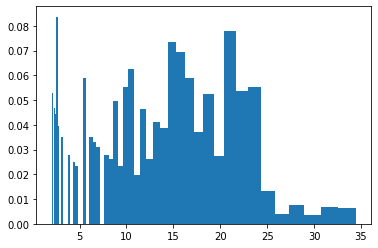

In [620]:
var = (dat['Δt'])[pts]
# var = var[np.isfinite(var)]
plt.hist(var,np.geomspace(var.min(),var.max()),density=True);

(158,)


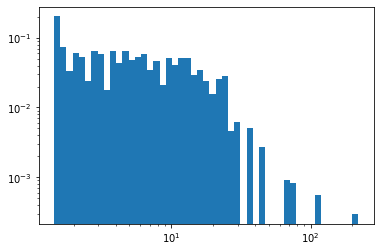

In [621]:
var = np.abs(dat['μ'][:,0]/dat['μ'][:,1])[pts]
# print(var.shape)
# var = var[np.isfinite(var)
print(var.shape)
plt.hist(var,np.geomspace(var.min(),var.max()),density=True);
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, '$|\\mu_1/\\mu_2|$')

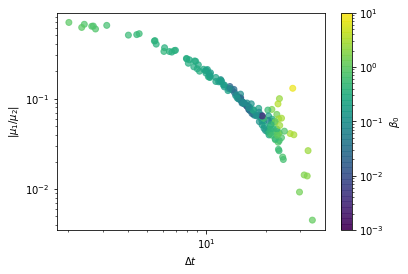

In [622]:
var1 = abs(dat['Δt'])
var2 = abs(dat['μ'][:,0]/dat['μ'][:,1])
var2 = np.where(var2>1,1/var2,var2)
var3 = (abs(dat['β'][:,1]))[pts]

scat = plt.scatter(var1[pts],var2[pts],c=var3,norm=colors.LogNorm(vmin=1e-3, vmax=10),alpha=0.7);
plt.colorbar(scat,label=r'$\beta_0$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'$|\mu_1/\mu_2|$')

Text(0.5, 0, '$\\beta_{\\rm min}$')

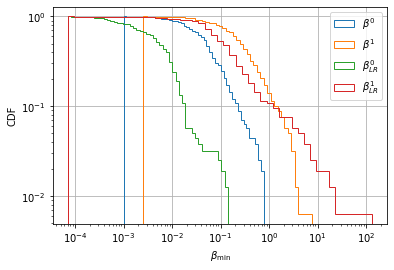

In [623]:
for var, lab in zip([dat['β'][:,0],dat['β'][:,1], dat['βLR'][:,0], dat['βLR'][:,1]], [r'$\beta^0$',r'$\beta^1$', r'$\beta^0_{LR}$',r'$\beta^1_{LR}$']):
    var = np.abs(var[pts])
    var = var[np.isfinite(var)]

    plt.hist(var,np.geomspace(var.min(),var.max()),alpha=1,density=True,label=lab,histtype='step',cumulative=-1)
    
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend();
plt.ylabel(r'CDF')
plt.xlabel(r'$\beta_{\rm min}$')
# plt.xlim(1e-4,None)

Text(0, 0.5, '$r$')

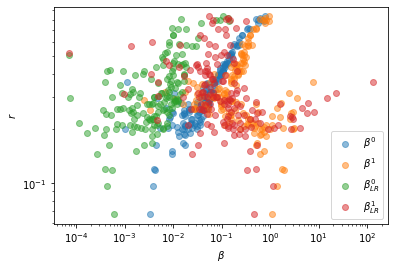

In [625]:
Asqrt=np.abs((dat['μ'][:,0]/dat['μ'][:,1])[pts])**0.5

for i,(var, lab) in enumerate(zip([dat['β'][:,0],dat['β'][:,1], dat['βLR'][:,0], dat['βLR'][:,1]], [r'$\beta^0$',r'$\beta^1$', r'$\beta^0_{LR}$',r'$\beta^1_{LR}$'])):
    var = np.abs(var[pts])
    var = var[np.isfinite(var)]

    plt.scatter(var,1/Asqrt,label=lab,alpha=0.5)
    
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$r$')

### Find trajectories where the first image is observable, but the second isn't 



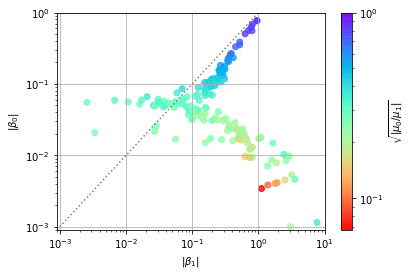

In [718]:
var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
bt0 = np.abs(dat['β'][:,0])[pts]
bt1 = np.abs(dat['β'][:,1])[pts]

colvar = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5

scat = plt.scatter(bt1,bt0,c=colvar,
                   alpha=0.8,cmap='rainbow_r',
                   norm=colors.LogNorm(colvar.min(),1)) 
#,norm=colors.LogNorm(colvar.min(),colvar.max()))
plt.colorbar(scat,label=r'$\sqrt{|\mu_0/\mu_1|}$')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0.9,20)
plt.xlabel(r'$|\beta_1|$')
plt.ylabel(r'$|\beta_0|$')
bt = np.geomspace(1e-3,10)
plt.xlim(.9e-3,10)
plt.ylim(.9e-3,1)
plt.plot(bt,bt,c='gray',ls=':')
plt.grid()

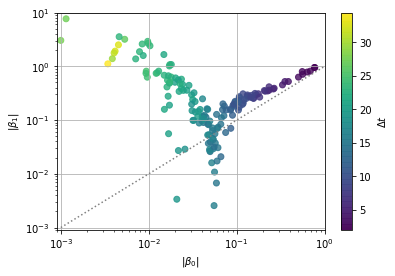

In [665]:
var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
bt0 = np.abs(dat['β'][:,0])[pts]
bt1 = np.abs(dat['β'][:,1])[pts]

colvar = dat['Δt'][pts]

scat = plt.scatter(bt0,bt1,c=colvar,alpha=0.8) #,norm=colors.LogNorm(colvar.min(),colvar.max()))
plt.colorbar(scat,label=r'$\Delta t$')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0.9,20)
plt.xlabel(r'$|\beta_0|$')
plt.ylabel(r'$|\beta_1|$')
bt = np.geomspace(1e-3,10)
plt.xlim(.9e-3,1)
plt.ylim(.9e-3,10)
plt.plot(bt,bt,c='gray',ls=':')
plt.grid()

In [ ]:
print('Fraction of trajectories with beta0>beta1')

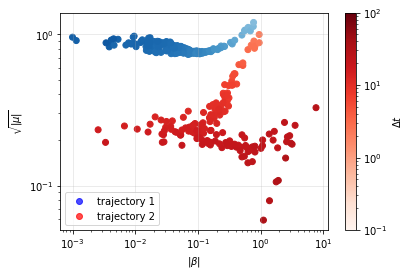

In [707]:
# cvar = np.abs(np.concatenate(dat['β'][:,0][pts],dat['β'][:,1][pts]))
cnorm = colors.LogNorm(0.1,100)

sct0 = plt.scatter(np.abs(dat['β'][:,0][pts]),dat['μ'][:,0][pts]**0.5,
                   c=np.abs(dat['Δt'][pts]),
                   cmap='Blues', 
                   norm=cnorm)

sct1 = plt.scatter(np.abs(dat['β'][:,1][pts]),np.abs(dat['μ'][:,1][pts])**0.5,
                   c=np.abs(dat['Δt'][pts]),
                   cmap='Reds', 
                   norm=cnorm)

# sctx = plt.scatter([],[],cmap='Grays', 
#                    norm=cnorm)
plt.scatter([],[],c='blue',alpha=.7,label='trajectory 1')
plt.scatter([],[],c='red',alpha=.7,label='trajectory 2')

plt.legend(loc='lower left')
plt.colorbar(sct1,label=r'$\Delta t$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$|\beta|$')
plt.ylabel(r'$\sqrt{|\mu|}$')
plt.grid(alpha=.3)

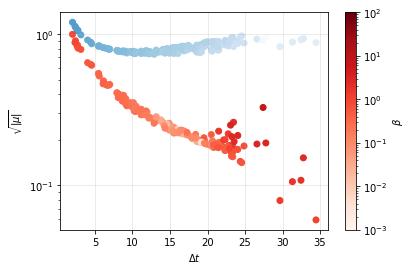

In [719]:
# cvar = np.abs(np.concatenate(dat['β'][:,0][pts],dat['β'][:,1][pts]))
cnorm = colors.LogNorm(1e-3,100)

sct0 = plt.scatter(dat['Δt'][pts],dat['μ'][:,0][pts]**0.5,
                   c=np.abs(dat['β'][:,0][pts]),
                   cmap='Blues', 
                   norm=cnorm,label='I')

sct1 = plt.scatter(dat['Δt'][pts],np.abs(dat['μ'][:,1][pts])**0.5,
                   c=np.abs(dat['β'][:,1][pts]),
                   cmap='Reds', 
                   norm=cnorm,label='II')

# sctx = plt.scatter([],[],cmap='Grays', 
#                    norm=cnorm)

plt.colorbar(sct1,label=r'$\beta$')
plt.yscale('log')
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'$\sqrt{|\mu|}$')
plt.grid(alpha=.3)

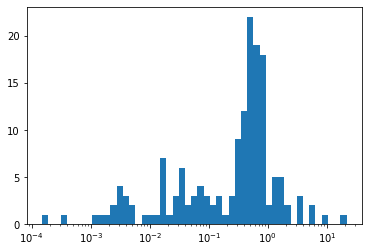

In [627]:
var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
plt.hist(var,np.geomspace(var.min(),var.max()))
plt.xscale('log')

Text(0, 0.5, '$\\Delta t$')

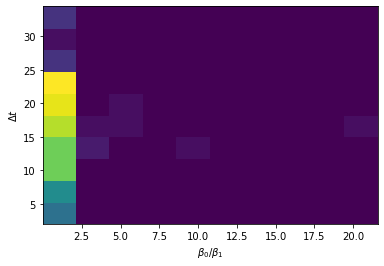

In [628]:
var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
plt.hist2d(var,dat['Δt'][pts],density=True)
# plt.xscale('log')
plt.xlabel(r'$\beta_0/\beta_1$')
plt.ylabel(r'$\Delta t$')

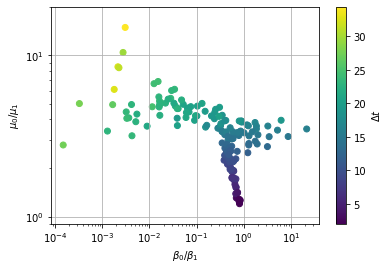

In [644]:
var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
bt0 = np.abs(dat['β'][:,0])[pts]

colvar = dat['Δt'][pts]
sizevar = 10000*dat['β'][:,0][pts]

scat = plt.scatter(var,1/Asqrt,c=colvar) #,norm=colors.LogNorm(colvar.min(),colvar.max()))
plt.colorbar(scat,label=r'$\Delta t$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.9,20)
plt.xlabel(r'$\beta_0/\beta_1$')
plt.ylabel(r'$\mu_0/\mu_1$')
plt.grid()

### Look at beta_LR

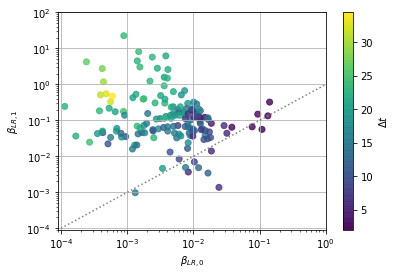

In [664]:
Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
bt0 = np.abs(dat['βLR'][:,0])[pts]
bt1 = np.abs(dat['βLR'][:,1])[pts]

colvar = dat['Δt'][pts]

scat = plt.scatter(bt0,bt1,c=colvar,alpha=0.8) #,norm=colors.LogNorm(colvar.min(),colvar.max()))
plt.colorbar(scat,label=r'$\Delta t$')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0.9,20)
plt.xlabel(r'$\beta_{LR,0}$')
plt.ylabel(r'$\beta_{LR,1}$')
bt = np.geomspace(1e-4,10)
plt.xlim(.9e-4,1)
plt.ylim(.9e-4,100)
plt.plot(bt,bt,c='gray',ls=':')
plt.grid()